In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 0.05           # rate Is -> Q



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ia0 = np.array([0, 0])     
Is0 = np.array([0, 0])     
Q0  = np.array([0, 0])
R0  = np.array([0, 0])     
S0  = N-(E0+A0+Ia0+Is0+R0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

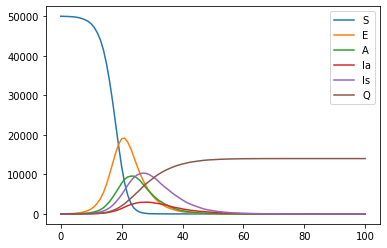

In [4]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')
plt.plot(data_array[:, 5*M], label='Q')

plt.legend()
plt.show()

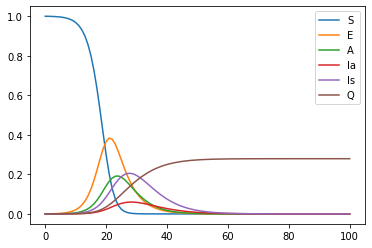

In [5]:
# load the data and rescale to intensive variables 
x = np.load('sto_traj.npy').astype('float')
x = x[:,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

det_model = pyross.deterministic.SEAIRQ(parameters, M, fi)
x_det = estimator.integrate(x[0], 0, Tf, det_model, contactMatrix)

plt.plot(x_det[:, 0], label='S')
plt.plot(x_det[:, M], label='E')
plt.plot(x_det[:, 2*M], label='A')
plt.plot(x_det[:, 3*M], label='Ia')
plt.plot(x_det[:, 4*M], label='Is')
plt.plot(x_det[:, 5*M], label='Q')
plt.legend()
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-4405.615789034076
1.441239833831787


In [7]:
alpha_g = 0.3
beta_g = 0.1
gIa_g = 0.2 
gIs_g = 0.2 
gE_g = 0.4
gA_g = 0.5 

guess = [alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]
params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, ftol=1e-6, verbose=True)

print('best estimates: ', params)
print('no. of iterations: ', nit)

For  [0.3 0.1 0.2 0.2 0.4 0.5] , (-log P):  285927.11927799793
For  [0.30001 0.1     0.2     0.2     0.4     0.5    ] , (-log P):  285927.4129503632
For  [0.3     0.10001 0.2     0.2     0.4     0.5    ] , (-log P):  285993.9239040989
For  [0.3     0.1     0.20001 0.2     0.4     0.5    ] , (-log P):  285927.0572429394
For  [0.3     0.1     0.2     0.20001 0.4     0.5    ] , (-log P):  285927.6004749744
For  [0.3     0.1     0.2     0.2     0.40001 0.5    ] , (-log P):  285930.7644830102
For  [0.3     0.1     0.2     0.2     0.4     0.50001] , (-log P):  285927.4564509476
For  [0.29995164 0.09998388 1.19999999 0.19996776 0.39993552 0.4999194 ] , (-log P):  334774.1394323452
For  [0.29996164 0.09998388 1.19999999 0.19996776 0.39993552 0.4999194 ] , (-log P):  334773.3621829486
For  [0.29995164 0.09999388 1.19999999 0.19996776 0.39993552 0.4999194 ] , (-log P):  334833.9614329048
For  [0.29995164 0.09998388 1.20000999 0.19996776 0.39993552 0.4999194 ] , (-log P):  334775.0388965261
For  

For  [0.29302085 0.01868972 0.13386789 0.18222993 0.31638461 0.48775365] , (-log P):  15210.15850886172
For  [0.29303085 0.01868972 0.13386789 0.18222993 0.31638461 0.48775365] , (-log P):  15210.415720876646
For  [0.29302085 0.01869972 0.13386789 0.18222993 0.31638461 0.48775365] , (-log P):  15206.415618715318
For  [0.29302085 0.01868972 0.13387789 0.18222993 0.31638461 0.48775365] , (-log P):  15210.06537272173
For  [0.29302085 0.01868972 0.13386789 0.18223993 0.31638461 0.48775365] , (-log P):  15210.912698016182
For  [0.29302085 0.01868972 0.13386789 0.18222993 0.31639461 0.48775365] , (-log P):  15211.596029257182
For  [0.29302085 0.01868972 0.13386789 0.18222993 0.31638461 0.48776365] , (-log P):  15210.841503836988
For  [0.27850073 0.01836052 0.09110511 0.13511924 0.19183102 0.45010433] , (-log P):  2984.810801921761
For  [0.27851073 0.01836052 0.09110511 0.13511924 0.19183102 0.45010433] , (-log P):  2985.092844011792
For  [0.27850073 0.01837052 0.09110511 0.13511924 0.1918310

For  [0.25952286 0.01987559 0.17369057 0.13311973 0.2007972  0.33179711] , (-log P):  -4197.4443938716995
For  [0.25951286 0.01988559 0.17369057 0.13311973 0.2007972  0.33179711] , (-log P):  -4197.704930894977
For  [0.25951286 0.01987559 0.17370057 0.13311973 0.2007972  0.33179711] , (-log P):  -4197.540383891991
For  [0.25951286 0.01987559 0.17369057 0.13312973 0.2007972  0.33179711] , (-log P):  -4197.502456151895
For  [0.25951286 0.01987559 0.17369057 0.13311973 0.2008072  0.33179711] , (-log P):  -4197.504534546619
For  [0.25951286 0.01987559 0.17369057 0.13311973 0.2007972  0.33180711] , (-log P):  -4197.530174083431
For  [0.25554945 0.01989752 0.16952816 0.13426766 0.20080004 0.33190035] , (-log P):  -4215.89565144994
For  [0.25555945 0.01989752 0.16952816 0.13426766 0.20080004 0.33190035] , (-log P):  -4215.818723187709
For  [0.25554945 0.01990752 0.16952816 0.13426766 0.20080004 0.33190035] , (-log P):  -4216.027555101436
For  [0.25554945 0.01989752 0.16953816 0.13426766 0.200

In [8]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = estimator.make_params_dict(params)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-4406.344818423005
1.320995807647705
